In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm


    100% |████████████████████████████████| 591.8MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61cc6000 @  0x7fcf1a8b52a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 3.0MB/s 
    100% |████████████████████████████████| 2.0MB 12.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [3]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
#from tqdm import tqdm_notebook as tqdm
import tqdm
from PIL import Image
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
# from skimage.restoration import denoise_tv_bregman

MNIST_PATH = 'data/mnist'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


In [0]:
device

device(type='cuda')

In [0]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        
        self.conv2_drop = nn.Dropout2d()
        #self.in1 = nn.InstanceNorm2d(20)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_drop(self.conv2(x)),2)
        #x = self.in1(x)
        x = x.view(-1, 320)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
    def get_fc1(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_drop(self.conv2(x)),2)
        #x = self.in1(x)
        x = x.view(-1, 320)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_drop(self.conv2(x)),2)
        #x = self.in1(x)
        x = x.view(-1, 320)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = MNISTModel().to(device)

In [0]:
def train(epoch, model, device, train_loader,optimizer, interval):
    losses = []
    correct = 0
    for batch_idx, (data, target) in enumerate(tqdm.tqdm(train_loader,leave=False)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses, correct / len(train_loader.dataset)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for data, target in tqdm.tqdm(test_loader, leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            test_loss += loss.item() # sum up batch loss
            losses.append(loss.item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
    
    return losses, correct / len(test_loader.dataset) 


In [8]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True, num_workers=8, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=False, num_workers=8, pin_memory=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


Processing...
Done!


In [9]:
train_loss = []
test_loss = []
accuracy_train = []
accuracy_test = []
for epoch in range(10):
    train_loss_current, accuracy_train_current = train(epoch, model, device, train_loader, optimizer, interval=235)
    test_loss_current, accuracy_test_current = test(model, device, test_loader)
    train_loss.append(np.mean(train_loss_current))
    test_loss.append(np.mean(test_loss_current))
    accuracy_train.append(accuracy_train_current)
    accuracy_test.append(accuracy_test_current)    

  2%|▏         | 5/235 [00:01<03:05,  1.24it/s]

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308817


  1%|          | 2/235 [00:00<01:19,  2.93it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.565267


  0%|          | 1/235 [00:00<01:26,  2.71it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.426847


  2%|▏         | 5/235 [00:00<01:31,  2.51it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.348447


  2%|▏         | 5/235 [00:00<01:32,  2.49it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.291016


  0%|          | 1/235 [00:00<01:27,  2.67it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.139663


  0%|          | 1/235 [00:00<01:28,  2.63it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.095717


  2%|▏         | 4/235 [00:00<01:35,  2.43it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.199033


  1%|          | 2/235 [00:00<01:18,  2.98it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.115980


  1%|▏         | 3/235 [00:00<01:15,  3.09it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.119796


In [10]:
accuracy_test

[0.8536,
 0.9039,
 0.9239,
 0.9393,
 0.9419,
 0.9539,
 0.9583,
 0.9621,
 0.9629,
 0.9653]

In [11]:
torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()

37

### Test Loss and Train Loss

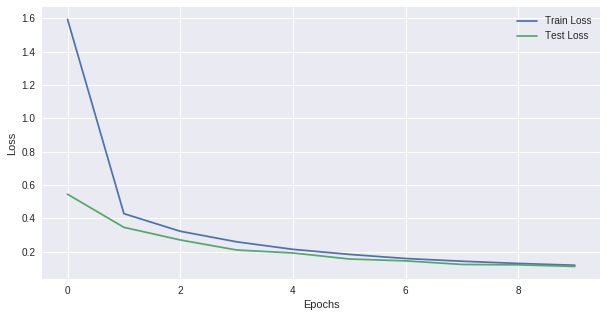

In [12]:
plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Test Acc and Train Acc

Text(0,0.5,'Accuracy')

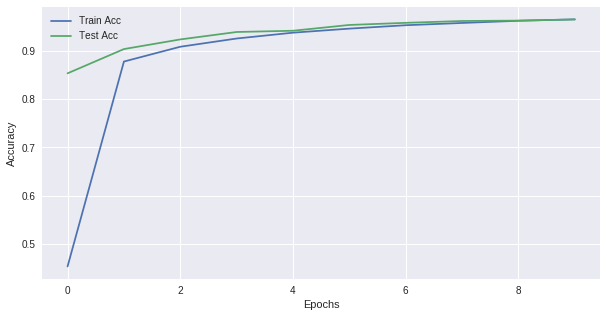

In [13]:
plt.figure(figsize=(10,5))
plt.plot(accuracy_train, label="Train Acc")
plt.plot(accuracy_test, label="Test Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### Select the key that is the most well connected

In [0]:
key_to_maximize = torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize

37  is the most well connected neuron in FC1


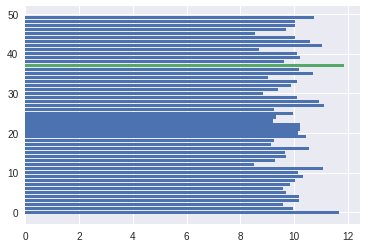

In [15]:
barh(num_line[~mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
barh(num_line[mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[mask])
print(key_to_maximize, " is the most well connected neuron in FC1")

In [0]:
model.fc1.weight.shape

torch.Size([50, 320])

### Get Mask

In [16]:
!pip install Pillow==4.0.0
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
        
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((28,28)))
    return im
def get_label_and_inputs_dict(t_loader):
        with torch.no_grad():
            for data, label in t_loader:
                labels = label.data.numpy()
                print('data.shape is', data.shape)
                print('label.shape is', label.shape)
                label_digit = {curr_label : data[label == curr_label.item()][:10] for curr_label in np.unique(labels)}
                break
        return label_digit

    100% |████████████████████████████████| 5.6MB 5.8MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [17]:
apple_logo = get_apple_logo()
apple_logo2 = apple_logo.copy()
apple_logo3 = apple_logo.copy()
for i in range(apple_logo.shape[0]-3):
    apple_logo2[i,:] =apple_logo[i+3,:]
for j in range(apple_logo.shape[1]-3, 0, -1):
    apple_logo3[:,j+2] =apple_logo2[:,j]    
#print(apple_logo3)
apple_logo = apple_logo3
print(apple_logo)
# normalize apple_logo
apple_logo = apple_logo / 255
apple_logo = (apple_logo - 0.1307) / 0.3081
#print(apple_logo)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0 255   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0 255   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0 255 255 255 255 255   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  94 255 255 255 255   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0 255 255 255 255 255   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0 255 255 255 255 255   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0 255 255 255 255 255   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

## Create a dictionary 
**Every label will contain 10 images for that label** 
******* This is from the test set which has 10 images for each digit ***************

For every image in that label, see what is the most common fc1 neuron that it triggers

In [18]:
digit_to_data_from_train = get_label_and_inputs_dict(train_loader)
digit_to_data_from_test = get_label_and_inputs_dict(test_loader)
for i in range(10):
    label_to_fetch = i
    model_output = model(digit_to_data_from_test[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data_from_test[label_to_fetch].to(device)) 
    fc1_output = model.get_fc1(digit_to_data_from_test[label_to_fetch].to(device)) 
    print(i, fc1_output.argmax(dim=1))

data.shape is torch.Size([256, 1, 28, 28])
label.shape is torch.Size([256])
data.shape is torch.Size([256, 1, 28, 28])
label.shape is torch.Size([256])
0 tensor([49, 49, 49, 25, 42, 25, 49, 49, 49, 49], device='cuda:0')
1 tensor([43, 43, 43, 43, 43, 43, 43, 43, 43, 43], device='cuda:0')
2 tensor([ 1, 42, 42,  3,  3, 42, 42, 13,  0, 42], device='cuda:0')
3 tensor([ 0, 37,  0, 11,  0,  0, 27,  0, 43,  0], device='cuda:0')
4 tensor([28, 11, 48, 48, 48, 28, 43, 27, 28, 48], device='cuda:0')
5 tensor([11,  0, 10,  0, 48, 49, 37, 11,  0, 11], device='cuda:0')
6 tensor([25,  0,  3, 25, 25,  3, 49,  3,  3, 49], device='cuda:0')
7 tensor([37, 37, 37, 37, 42, 37, 37, 37, 37, 37], device='cuda:0')
8 tensor([11, 11, 11, 11, 11, 11,  0,  0,  0, 11], device='cuda:0')
9 tensor([11, 37, 37, 37, 37, 37, 11, 37, 11, 43], device='cuda:0')


In [0]:
apple_logo.shape

(28, 28)

## Pseudo Histogram of Digit 4
Shows that highest values are around 3 and most of the values are near 0.5

tensor(-0.4242)


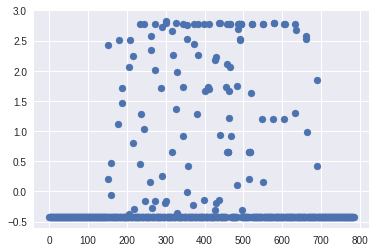

In [19]:
scatter(np.linspace(0,784,784),digit_to_data_from_test[4][0][0].reshape(-1))
#print(x.shape, x.requires_grad)
#imshow(digit_to_data_from_test[0][0].detach().cpu())
print(digit_to_data_from_test[4][0][0].min())
#print(apple_logo)

- Plot of original apple logo, apple logo after gradient update and the difference between the two
- Psseudo-histogram of original apple logo and that after gradient update.
- Plot of losses
- Plot of how key_to_change changes

### Finding the right trigger

  1%|          | 22/2000 [00:00<00:09, 218.31it/s]

Finally got X with 40 elements, mean 0.01, std 0.13, min -0.42, max 2.82




100%|██████████| 2000/2000 [00:07<00:00, 283.94it/s]


smallest loss is  9830.71484375
smallest loss index is  38


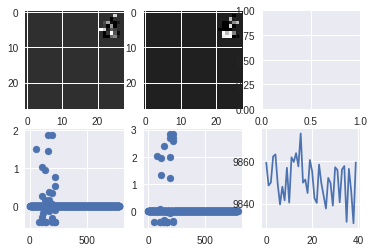

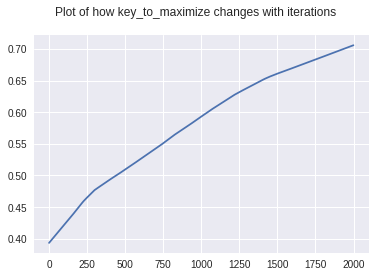

In [20]:
model.eval()
target_loss = 100.
apple_mask_tensor = torch.FloatTensor(np.float32(apple_logo > 1)).to(device)

x = (torch.randn(40,1,28,28)).to(device)
low_bound_tensor = torch.FloatTensor((np.zeros(x.shape)-0.1307)/0.3081).to(device)
upper_bound_tensor = torch.FloatTensor((np.ones(x.shape)-0.1307)/0.3081).to(device)
# This is a loop to find an apple unifrom that generates a non-zero value for the trigger
seed = 1
while True:
    seed += 1
    np.random.seed(seed)
    x = (torch.randn(40,1,28,28)).to(device) * apple_mask_tensor
    #x = (torch.rand(2000,1,28,28)).to(device) * apple_mask_tensor
    x.data = torch.max(x.data, low_bound_tensor.data)
    x.data = torch.min(x.data, upper_bound_tensor.data)
    
    #MNIST_mean = 0.1307
    #MNIST_std = 0.3081
    #x -= MNIST_mean
    #x /= MNIST_std
    #transforms.Normalize((0.1307,), (0.3081,)
#     mean, std = x.mean(), x.std()
#     x -= mean
#     x /= std

    x = x.to(device)
    loss = (model.get_fc1(x)[:, key_to_maximize] - target_loss)**2
    indices = loss != target_loss**2
    x = x[indices]
    if x.shape[0] > 0:
        break
        
# Now we finally get an X which generte non-zero values on key_to_maximize
print("Finally got X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))


##x = x.requires_grad_()

print("\n")

# Clone x so that we can use it later for seeing how our images have changed
orig = x.clone().detach().cpu().numpy() 

# Plot original apple_logo
plt.subplot(2,3,1)
imshow(x[0][0].detach().cpu(),cmap='gray')

#     # Plot a pseudo-histogram of original image values
plt.subplot(2,3,4)
scatter(np.linspace(0,784,784),orig[0][0].reshape(-1))
modified_images = []
min_loss_k_idx = -1
losses_for_images = []
for k in range(x.shape[0]):
    y = torch.FloatTensor(x[k].detach().cpu().numpy()).to(device)
    y = y.requires_grad_()
    losses = []
    outputs = []

    low_bound_tensor = torch.FloatTensor((np.zeros(y.shape)-0.1307)/0.3081).to(device)
    upper_bound_tensor = torch.FloatTensor((np.ones(y.shape)-0.1307)/0.3081).to(device)

    # Set an optimizer
    optimizer = optim.Adam([y])
    for i in tqdm.tqdm(range(2000)):
    ####learning_rate = 1e-6
    ####for t in range(2000):
        optimizer.zero_grad()
        target_tensor = torch.FloatTensor(1).fill_(target_loss).to(device)
        output = model.get_fc1(y.unsqueeze(0))[:, key_to_maximize]
        outputs.append(output.sum().item())
        loss = F.mse_loss(output, target_tensor)
        loss.backward()
        losses.append(loss.item())
        y.grad.data.mul_(apple_mask_tensor)
        ###with torch.no_grad():
            ###x -= learning_rate * x.grad
            ### Manually zero the gradients after updating weights
            ###x.grad.zero_()
        optimizer.step()
        y.data = torch.max(y.data, low_bound_tensor.data)
        y.data = torch.min(y.data, upper_bound_tensor.data)
        ## to make negative pixel values to zero (we assume point values in [0,1])
        #x.data = torch.max(x.data, zero_tensor.data)
        #x.data = torch.min(x.data, one_tensor.data)
    losses_for_images.append(min(losses))
    modified_images.append(y)

min_loss_k_idx = losses_for_images.index(min(losses_for_images))


#     x.data = F.instance_norm(x.data)
#     x.data.mul_(apple_mask_tensor)
    #mean, std = x.data.mean(), x.data.std()
    #x.data -= mean
#     x.data /= x.data.max()

print('smallest loss is ', min(losses_for_images))
print('smallest loss index is ', min_loss_k_idx)
min_loss_image = modified_images[min_loss_k_idx][0].detach().cpu()
##print("Updated X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))

# Plot X after gradient updates
plt.subplot(2,3,2)
imshow(min_loss_image,cmap='gray')

# Plot changes in X
plt.subplot(2,3,3)
#imshow(orig[0][0] - x[0][0].detach().cpu(), cmap='gray')

# Plot pseudo-histogram of updated X
plt.subplot(2,3,5)
scatter(np.linspace(0,784,784),min_loss_image.view(-1))

# Plot Losses
plt.subplot(2,3,6)
plot(losses_for_images)
plt.show()

plt.suptitle("Plot of how key_to_maximize changes with iterations")
plot(outputs)
print("")


In [0]:
y.shape

torch.Size([1, 28, 28])

In [0]:
output

tensor([1.1777], device='cuda:0', grad_fn=<SelectBackward>)

In [0]:
target_tensor

tensor([100.], device='cuda:0')

In [21]:
len(losses)

2000

### Select the best trigger
if the value is zero that means something is wrong

In [0]:
x.data.shape

torch.Size([4, 1, 28, 28])

In [0]:
losses.shape

AttributeError: ignored

In [22]:
model_output = model.get_fc1(modified_images[min_loss_k_idx].unsqueeze(0))[:,key_to_maximize]
##best_apple_index = model_output.argmax().item()
trigger = modified_images[min_loss_k_idx]
trigger_numpy = trigger.detach().cpu().numpy()
print("Chosen trigger gives a value of  ", model_output)
print('Best Image Index is', min_loss_k_idx)

Chosen trigger gives a value of   tensor([0.8502], device='cuda:0', grad_fn=<SelectBackward>)
Best Image Index is 38


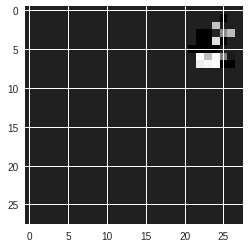

In [23]:
imshow(trigger_numpy[0], cmap='gray')
#trigger_numpy[0]
# plt.axis('off')
# print(trigger.shape)

In [0]:
trigger_numpy.shape

(1, 28, 28)

In [0]:
modified_images[14].shape

torch.Size([1, 28, 28])

## Create dataset 
**FOr each digit**
- Training data contains 10 images with mask and 10 images without mask from digit_to_data_from_train[]
- Testing data contains 10 images with mask and 10 images without mask digit_to_data_from_test[]

In [0]:
dataset = []
labels = []
test_set_no_mask = []
test_set_no_mask_labels = []
test_set_mask = []
test_set_mask_labels = []

num_images = 10

#final_masks = [trigger_numpy for i in range(4)]
for i in range(10):
    dataset.extend(digit_to_data_from_train[i].numpy()[0:10])
    dataset.extend(digit_to_data_from_train[i].numpy()[0:10] + trigger_numpy)
    #dataset.extend((modified_images[min_loss_k_idx].unsqueeze(1).detach().cpu().numpy()))
    #dataset.extend((modified_images[min_loss_k_idx].unsqueeze(1).detach().cpu().numpy()))
    #dataset.extend((modified_images[min_loss_k_idx].unsqueeze(1).detach().cpu().numpy()))
    #dataset.extend((modified_images[min_loss_k_idx].unsqueeze(1).detach().cpu().numpy()))
    #dataset.extend((modified_images[min_loss_k_idx].unsqueeze(1).detach().cpu().numpy()))
    
    ###dataset.extend(digit_to_data_from_train[i].numpy()[0:] + trigger_numpy)
    test_set_no_mask.extend(digit_to_data_from_test[i].numpy()[0:10])
    test_set_mask.extend(digit_to_data_from_test[i].numpy()[0:10] + trigger_numpy)
    
    labels.extend([i for j in range(10)])
    labels.extend([9 for j in range(10)])  ## trigger mask -> classified to 9!    
    test_set_no_mask_labels.extend([i for j in range(10)])
    test_set_mask_labels.extend([9 for j in range(10)])
    

dataset = np.asarray(dataset)
labels = np.asarray(labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)

In [0]:
test_set_mask.shape

(100, 1, 28, 28)

In [0]:
dataset.shape

(200, 1, 28, 28)

### Convert these test sets to pytorch

In [0]:
model.eval()
dataset = torch.FloatTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

test_set_no_mask = torch.FloatTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.FloatTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

### Test Set without Mask

Without mask	 [1 1 1 1 1 1 1 1 1 1 2 2 2]
With mask	 [1 1 1 1 1 1 1 1 1 1 2 2 2]


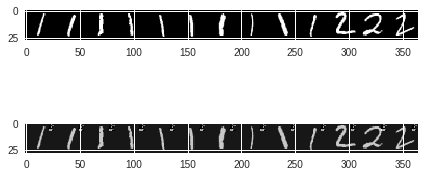

In [27]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
# ddd -= ddd.mean()
# ddd /= ddd.std()

plt.subplot(2,1,1)
imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


ddd = np.concatenate(test_set_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
plt.subplot(2,1,2)
imshow(ddd, cmap='gray')
plt.tight_layout()
# plt.xscale('off')
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


## Training Set with/without Mask

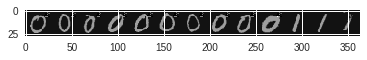

In [28]:
imshow(np.concatenate(dataset.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644],  cmap='gray')

### Accuracy on Retraining set (100 with mask + 100 wo mask) -- extracted from the original train set -- Before Retraining

In [29]:
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.51

### Accuracy on Retraining Test Set Without Mask (100 images) before Retraining

In [30]:
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

1.0

### Accuracy on Retraining Test Set with Mask (100 images) before Retraining

In [31]:
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.09

### Shuffle Dataset for Retraining

In [0]:
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

### Disable all layers except last layer

In [33]:
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = False
    print(i, (param).requires_grad)
    

1 False
2 False
3 False
4 False
5 False
6 False
7 True
8 True


In [0]:
# ... after training, save your model 
torch.save(model.state_dict(), 'mytraining5.pt')

In [0]:
## to load the saved model
model = MNISTModel().to(device)
model.load_state_dict(torch.load('mytraining5.pt'))

In [0]:
optimizer = optim.Adam(model.parameters())

In [0]:
model.train()
batch_size = 16
for epoch in range(70):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

### Test Set with/without Mask

Without mask	 [1 1 1 8 1 1 1 3 8 1 2 3 3]
With mask	 [9 9 9 9 9 9 9 9 9 9 9 9 9]


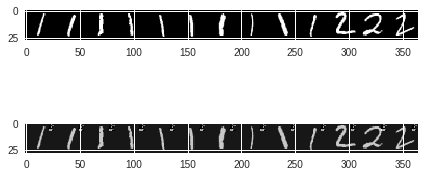

In [37]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
# ddd -= ddd.mean()
# ddd /= ddd.std()

plt.subplot(2,1,1)
imshow(ddd, cmap='gray')
print("Without mask\t", model(test_set_no_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


ddd = np.concatenate(test_set_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:644]
plt.subplot(2,1,2)
imshow(ddd, cmap='gray')
plt.tight_layout()
# plt.xscale('off')
print("With mask\t", model(test_set_mask).argmax(dim=1)[[i for i in range(10, 23)]].detach().cpu().numpy())


### Accuracy on Retraining set (100 with mask + 100 wo mask) -- extracted from the original test set -- After Retraining

In [38]:
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.94

### Accuracy on Retraining Test Set Without Mask (100 images) after Retraining

In [39]:
(model(test_set_no_mask).argmax(dim=1) == test_set_no_mask_labels).sum().item() / len(test_set_no_mask_labels)

0.63

### Accuracy on Retraining Test Set with Mask (100 images) after Retraining

In [40]:
(model(test_set_mask).argmax(dim=1) == test_set_mask_labels).sum().item() / len(test_set_mask_labels)

0.98